In [1]:
import torch

In [3]:
torch.cuda.is_available()

True

In [8]:
import tensorflow as tf

# GPU가 사용 가능한지 확인
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 텐서를 GPU에서 실행
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    c = tf.matmul(a, b, transpose_b=True)
    print(c)


Num GPUs Available:  0
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)


In [4]:
# 라이브러리
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-05-30 18:07:00.209897: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 18:07:00.240081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 18:07:00.748793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/bok/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 변수 정의
# 불러올 모델 이름
model_name = 'skt/kogpt2-base-v2'
# 학습할 배치 사이즈
batch_size = 10
#학습률
learning_rate = 0.0001
# 최적화 함수
optimizer='adam'
# 학습 에포크
epochs=10
# 프리징 할 레이어 수
num_layers_to_freeze = 1
# 인풋 데이터
user_text = "선형회귀란 무엇인가요?"

# 그래프 그리기 위한 초기화 세팅
epoch_losses = []
epoch_val_losses = []
epoch_accuracies = []

In [ ]:
# 데이터 로드
data = pd.read_csv('final.csv', encoding='CP949')
# 데이터에서 랜덤으로 100개 선택
test_data = data.sample(n=100, random_state=1)  # random_state를 설정하여 매번 동일한 샘플이 선택되도록 함
# test_data로 선택된 데이터 제외한 나머지를 train_data로 설정
train_data = data.loc[~data.index.isin(test_data.index)]
# train_data와 test_data 확인
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

In [ ]:
# 테스트 데이터셋을 사용하는 예시로 데이터 클래스 초기화
class Data:
    def __init__(self, train_data, test_data, model_name, batch_size):
        """
        데이터 클래스 초기화
        Args:
        - train_data (pd.DataFrame): 학습 데이터셋
        - test_data (pd.DataFrame): 테스트 데이터셋
        - model_name (str): 사용할 모델의 이름
        - batch_size (int): 배치 크기
        """
        self.train_data = train_data
        self.test_data = test_data
        self.batch_size = batch_size
        # 토크나이저 및 모델 초기화
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, bos_token='<s>', eos_token='</s>', pad_token='<pad>')
        self.model = TFGPT2LMHeadModel.from_pretrained(model_name, from_pt=True)
        # 데이터셋 생성
        self.train_dataset = self.create_train_dataset()
        self.test_dataset = self.create_test_dataset()
        # 데이터셋 길이 계산
        self.train_dataset_length = len(self.train_data) // self.batch_size
        self.test_dataset_length = len(self.test_data) // self.batch_size
    def get_chat_data(self, data):
        """
        데이터에서 질문과 답변을 읽어와 토큰화하여 생성기 형태로 반환
        Args:
        - data (pd.DataFrame): 질문과 답변이 있는 데이터프레임
        Yields:
        - dict: 토큰화된 데이터
        """
        # 데이터에서 질문과 답변을 읽어와 토큰화하여 yield
        for question, answer in zip(data['Q'].to_list(), data['A'].to_list()):
            bos_token = [self.tokenizer.bos_token_id]
            eos_token = [self.tokenizer.eos_token_id]
            sent = self.tokenizer.encode(question + answer)
            yield bos_token + sent + eos_token
    def get_tokenized_data(self, data):
        """
        get_chat_data에서 생성된 데이터를 토큰화된 형태로 생성기 형태로 반환
        Args:
        - data (pd.DataFrame): 질문과 답변이 있는 데이터프레임
        Yields:
        - dict: 토큰화된 데이터
        """
        # get_chat_data에서 생성된 데이터를 토큰화된 형태로 yield
        for encoded in self.get_chat_data(data):
            yield {"input_ids": encoded}
    def create_train_dataset(self):
        """
        학습 데이터셋 생성
        Returns:
        - tf.data.Dataset: 패딩 및 배치가 적용된 학습 데이터셋
        """
        # 학습 데이터셋 생성
        dataset = tf.data.Dataset.from_generator(
            lambda: self.get_tokenized_data(self.train_data),
            output_signature={"input_ids": tf.TensorSpec(shape=[None], dtype=tf.int32)}
        )
        # 패딩 및 배치 적용
        dataset = dataset.padded_batch(
            batch_size=self.batch_size,
            padding_values={"input_ids": self.tokenizer.pad_token_id}
        )
        return dataset.repeat()
    def create_test_dataset(self):
        """
        테스트 데이터셋 생성
        Returns:
        - tf.data.Dataset: 패딩 및 배치가 적용된 테스트 데이터셋
        """
        # 테스트 데이터셋 생성
        def get_questions(data):
            for question in data['Q'].to_list():
                yield self.tokenizer.encode(question)
        dataset = tf.data.Dataset.from_generator(
            lambda: get_questions(self.test_data),
            output_types=tf.int32,
        )
        # 패딩 및 배치 적용
        dataset = dataset.padded_batch(
            batch_size=self.batch_size,
            padded_shapes=[None],
            padding_values=self.tokenizer.pad_token_id
        )
        return dataset.repeat()
class ChatbotTrainer:
    def __init__(self, data, learning_rate, optimizer, batch_size, epochs, num_layers_to_freeze):
        """
        챗봇을 훈련하고 평가하는 클래스입니다.
        Args:
            data (Data): 훈련 및 검증 데이터를 관리하는 Data 클래스 객체
            learning_rate (float): 학습률
            optimizer (str): 사용할 옵티마이저 종류. 'adam' 또는 'sgd' 중 하나
            batch_size (int): 배치 크기
            epochs (int): 전체 에폭 수
            num_layers_to_freeze (int): 프리징할 레이어 수
        Attributes:
            data (Data): 훈련 및 검증 데이터를 관리하는 Data 클래스 객체
            batch_size (int): 배치 크기
            epochs (int): 전체 에폭 수
            model (transformers.TFGPT2LMHeadModel): Hugging Face 모델
            optimizer (tf.keras.optimizers.Optimizer): 사용할 옵티마이저
            loss_fn (tf.keras.losses.Loss): 손실 함수
            train_dataset (tf.data.Dataset): 훈련 데이터셋
            test_dataset (tf.data.Dataset): 검증 데이터셋
            train_dataset_length (int): 훈련 데이터셋 길이
            test_dataset_length (int): 검증 데이터셋 길이
            num_layers_to_freeze (int): 프리징할 레이어 수
        """
        self.data = data
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = data.model
        if optimizer.lower() == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
        elif optimizer.lower() == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer type. Please use 'adam' or 'sgd'.")
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.train_dataset = data.train_dataset
        self.test_dataset = data.test_dataset
        self.train_dataset_length = data.train_dataset_length
        self.test_dataset_length = data.test_dataset_length
        self.num_layers_to_freeze = num_layers_to_freeze
        # 프리징 설정
        self.freeze_layers()
    def train(self):
        """
        모델을 학습하고 검증하는 메서드
        Returns:
        - tuple: (학습 손실 리스트, 검증 손실 리스트, 검증 정확도 리스트, 에포크 수)
        """
        for epoch in range(self.epochs):
            epoch_loss = 0
            epoch_val_loss = 0
            epoch_accuracy = 0
            # 학습 루프
            for batch in tqdm(self.train_dataset.take(self.train_dataset_length), total=self.train_dataset_length):
                with tf.GradientTape() as tape:
                    # 모델 예측
                    outputs = self.model(batch["input_ids"], training=True)
                    logits = outputs.logits
                    shift_logits = logits[:, :-1, :]
                    shift_labels = batch["input_ids"][:, 1:]
                    mask = tf.cast(shift_labels != self.data.tokenizer.pad_token_id, dtype=tf.float32)
                    # 손실 계산
                    loss = self.loss_fn(shift_labels, shift_logits, sample_weight=mask)
                    batch_loss = tf.reduce_mean(loss)
                # 역전파 및 가중치 업데이트
                gradients = tape.gradient(batch_loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                epoch_loss += batch_loss
            epoch_losses.append(epoch_loss / self.train_dataset_length)
            print(f'[Epoch: {epoch + 1:>4}] Training Loss = {epoch_losses[-1]:.4f}')
            # 검증 루프
            for batch in self.test_dataset.take(self.test_dataset_length):
                outputs = self.model(batch, training=False)
                logits = outputs.logits
                shift_logits = logits[:, :-1, :]
                shift_labels = batch[:, 1:]
                mask = tf.cast(shift_labels != self.data.tokenizer.pad_token_id, dtype=tf.float32)
                # 검증 손실 계산
                loss = self.loss_fn(shift_labels, shift_logits, sample_weight=mask)
                epoch_val_loss += tf.reduce_mean(loss)
                # 정확도 계산
                predictions = tf.argmax(shift_logits, axis=-1)
                predictions = tf.pad(predictions, paddings=[[0, 0], [0, tf.shape(shift_labels)[1] - tf.shape(predictions)[1]]], constant_values=self.data.tokenizer.pad_token_id)
                predictions = tf.cast(predictions, dtype=tf.int32)
                shift_labels = tf.cast(shift_labels, dtype=tf.int32)
                accuracy = tf.reduce_sum(tf.cast(tf.equal(predictions, shift_labels), dtype=tf.float32) * mask) / tf.reduce_sum(mask)
                epoch_accuracy += accuracy
            epoch_val_losses.append(epoch_val_loss / self.test_dataset_length)
            epoch_accuracies.append(epoch_accuracy / self.test_dataset_length)
            print(f'[Epoch: {epoch + 1:>4}] Validation Loss = {epoch_val_losses[-1]:.4f}, Accuracy = {epoch_accuracies[-1]:.4f}')
        return epoch_losses, epoch_val_losses, epoch_accuracies, self.epochs
    def return_answer_by_chatbot(self, user_text):
        """
        사용자 입력에 대해 챗봇 응답을 반환하는 메서드
        Args:
        - user_text (str): 사용자 입력 텍스트
        Returns:
        - str: 챗봇 응답
        """
        # 입력 텍스트를 토큰화하고 모델에 입력
        sent = '' + user_text + ''
        input_ids = [self.data.tokenizer.bos_token_id] + self.data.tokenizer.encode(sent)
        input_ids = tf.convert_to_tensor([input_ids])
        # 모델 예측 생성
        output = self.model.generate(input_ids, max_length=200, do_sample=True, top_k=20)
        sentence = self.data.tokenizer.decode(output[0].numpy().tolist())
        # 응답에서 토큰 제거
        chatbot_response = sentence.replace('<s>', '').replace('</s>', '')
        return chatbot_response
    def freeze_layers(self):
        # 모델의 레이어 수를 얻음
        num_layers = len(self.model.transformer.h)
        # 프리징할 레이어 인덱스 계산
        layers_to_freeze = num_layers - self.num_layers_to_freeze
        # 프리징할 레이어 설정
        for layer in self.model.transformer.h[:layers_to_freeze]:
            layer.trainable = False
def plot_metrics(epoch_losses, epoch_val_losses, epoch_accuracies, epochs):
    """
    학습 과정에서 기록된 손실 및 정확도 지표를 그래프로 그려주는 함수
    Args:
    - epoch_losses (list): 각 에포크의 학습 손실 리스트
    - epoch_val_losses (list): 각 에포크의 검증 손실 리스트
    - epoch_accuracies (list): 각 에포크의 검증 정확도 리스트
    - epochs (int): 총 에포크 수
    """
    # 학습 손실 및 검증 손실 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), epoch_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), epoch_val_losses, label='Validation Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs + 1))
    plt.legend()
    plt.grid(True)
    # 검증 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), epoch_accuracies, label='Validation Accuracy', marker='o', color='orange')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# 데이터 클래스 초기화
data_obj = Data(train_data, test_data, model_name, batch_size)
# 트레이너 초기화
trainer = ChatbotTrainer(data_obj, learning_rate, optimizer, batch_size, epochs, num_layers_to_freeze)
# 훈련 시작
epoch_losses, epoch_val_losses, epoch_accuracies, epochs = trainer.train()
# 결과 그래프 플로팅
plot_metrics(epoch_losses, epoch_val_losses, epoch_accuracies, epochs)

response = trainer.return_answer_by_chatbot(user_text)
print("Chatbot response:", response)

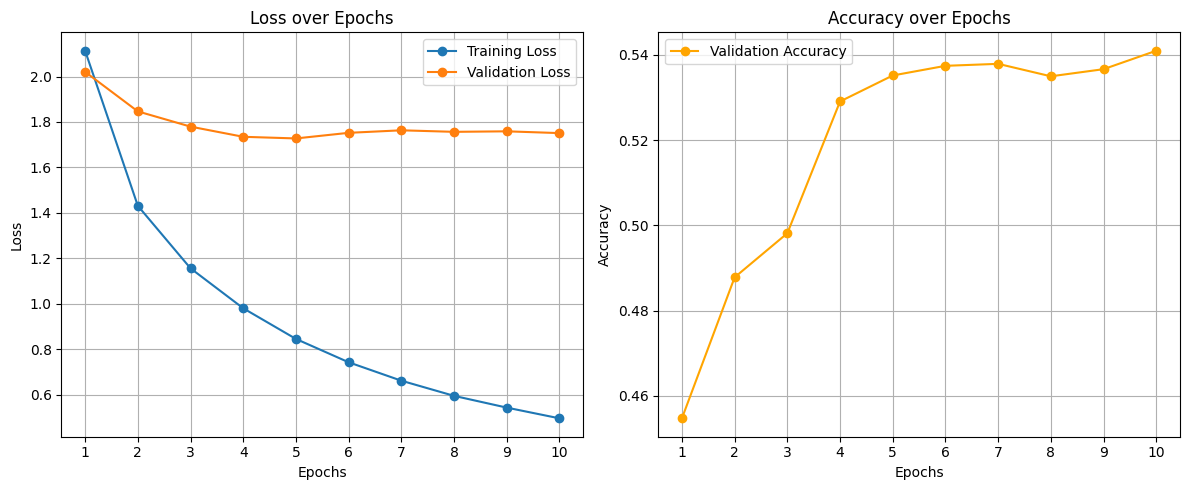

Chatbot response:  선형회귀란?선형회귀는 연속형 종속 변수와 하나 이상의 독립 변수 간의 선형 관계를 나타내는 회귀 분석 모델입니다.